# C: Python Implementation
### Authors: Ethan Rajkumar

Last Modified: Sunday April 21st, 2024 by Ethan Rajkumar


In [1]:
#importing the necessary libraries
import numpy as np
from lib import *
import pandas as pd
import pennylane as qml
from lib.cr2dataset import hartree, get_pot_cr2
from lib.cr2dataset import cr2_params
from lib.qpe import QPE 
import jax
from jax import random
from lib.phase_estimation import *
import phayes
import jax.numpy as jnp
import random as r 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

/var/folders/k9/jxn4k2_s1v50xzyqggp1kft40000gn/T/ipykernel_85851/2955796516.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Part 1 Hamiltonian Generation
### 1.1 : Interpotential Curve Point Selection

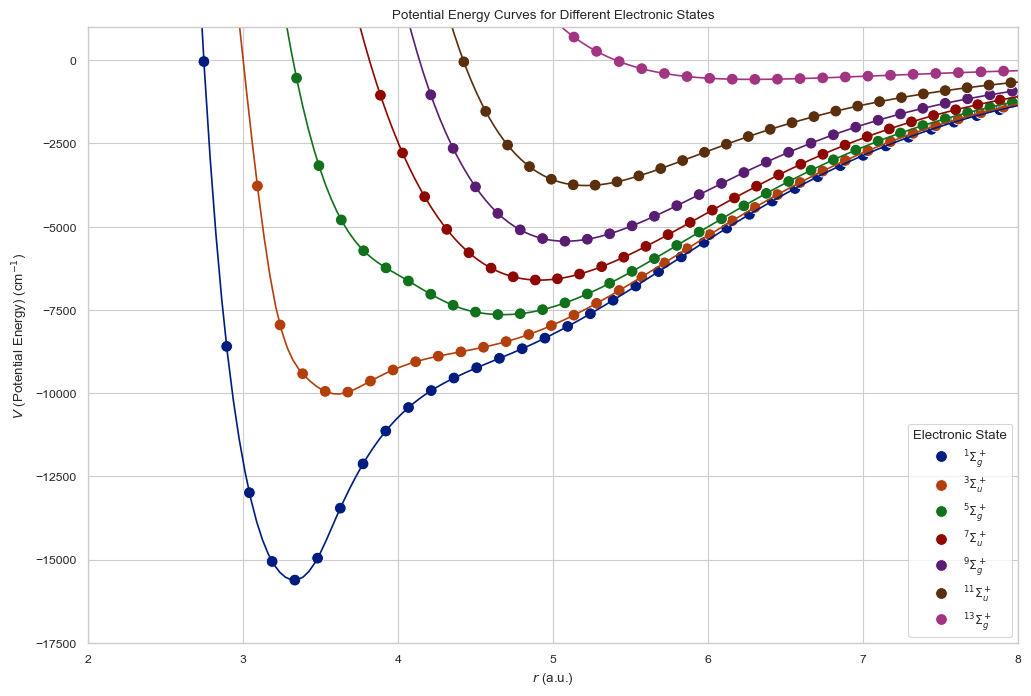

In [2]:
# Set the Seaborn theme and color palette
sns.set_theme(context='paper', style='whitegrid')
dark_palette = sns.color_palette("dark", n_colors=7)  # Using a darker palette

# Initialize DataFrame to store the potential data
data_32 = pd.DataFrame()
data_1000 = pd.DataFrame()
states = [1, 3, 5, 7, 9, 11, 13]
labels = ['${}^1\Sigma_g^+$', '${}^3\Sigma_u^+$', '${}^5\Sigma_g^+$', '${}^7\Sigma_u^+$',
          '${}^9\Sigma_g^+$', '${}^{11}\Sigma_u^+$', '${}^{13}\Sigma_g^+$']

# Fetch potential data for each state and accumulate it in the DataFrames
for i, state in enumerate(states):
    pot, lims = get_pot_cr2(state)
    rs_1000 = np.linspace(lims[0], lims[1], 1000)
    rs_32 = np.linspace(start=lims[0], stop=lims[1], num=256)
    potentials_32 = pot(rs_32) * hartree
    potentials_1000 = pot(rs_1000) * hartree
    temp_df_32 = pd.DataFrame({'r (a.u.)': rs_32, 'V (cm^-1)': potentials_32, 'State': labels[i]})
    temp_df_1000 = pd.DataFrame({'r (a.u.)': rs_1000, 'V (cm^-1)': potentials_1000, 'State': labels[i]})
    data_32 = pd.concat([data_32, temp_df_32], ignore_index=True)
    data_1000 = pd.concat([data_1000, temp_df_1000], ignore_index=True)


plt.figure(figsize=(12, 8))
sns.lineplot(
    data=data_1000,
    x='r (a.u.)',
    y='V (cm^-1)',
    hue='State',
    palette=dark_palette,
    legend=None
)


sns.scatterplot(
    data=data_32,
    x='r (a.u.)',
    y='V (cm^-1)',
    hue='State',
    palette=dark_palette,
    s=72,  # Adjust the size of the scatter plot markers
    edgecolor="w",
    legend='full'
)

# Configure plot aesthetics 
plt.ylim((-17500, 1000))
plt.xlim((2, 8))
plt.xlabel(r'$r$ (a.u.)')
plt.ylabel(r'$V$ (Potential Energy) (cm$^{-1}$)')
plt.title('Potential Energy Curves for Different Electronic States')
plt.legend(title='Electronic State', loc='lower right')

# Display the plot
plt.show()




### 1.2: Generating the Hamiltonians for all Spin States



In [3]:

mol_params =  cr2_params
list_of_spins = [1, 3, 5, 7, 9, 11, 13]
list_of_params32 = [[2.8, 4], [3.2, 4.5], [4, 6.5], [4.3, 6.8], [4.5, 7], [4.6, 7], [5.2, 9]]

hamiltonians = create_hamiltonians(list_of_spins, list_of_params32, mol_params=mol_params)

for i, spin in enumerate(list_of_spins):
    params = list_of_params32[i]
    variable_name = f"h_dvr_{spin}"
    decomposed_hamiltonian = qml.pauli_decompose(hamiltonians[(spin, tuple(params))])
    globals()[variable_name] = decomposed_hamiltonian




### 1.3 Conversion of the hamiltonians into a unitary matrix 

In [4]:
wire_order = [0, 1, 2, 3, 4]
n = 5 
for spin in list_of_spins:
    variable_name = f"ufss{spin}"
    hamiltonian = globals()[f"h_dvr_{spin}"]
    unitary = convert_to_unitary(hamiltonian, n, wire_order)
    globals()[variable_name] = unitary
    



## 1.4 Find the true phases of the unitary matrices 

In [5]:
for spin in list_of_spins:
    unitary_matrix = globals()[f"ufss{spin}"]
    phase = find_true_phases(unitary_matrix) 
    phase = phase/np.linalg.norm(phase)
    phase = np.abs(phase/(2*np.pi))
    globals()[f"phase{spin}"] = phase



In [6]:
for spin in list_of_spins:
    phase = globals()[f"phase{spin}"]
    print(phase.shape)
    print(f"True phases for spin state {spin}: {phase}")



(32,)
True phases for spin state 1: [0.04096298 0.04450851 0.03373529 0.03641698 0.04883094 0.04707422
 0.04618917 0.04335729 0.04236002 0.04286075 0.03153212 0.02933257
 0.02824815 0.02153788 0.02175125 0.0180878  0.01859339 0.0256471
 0.0104862  0.00672655 0.00572107 0.00376777 0.00121464 0.00027203
 0.02241888 0.02029003 0.01805162 0.01533049 0.01363865 0.00616677
 0.00840116 0.00825458]
(32,)
True phases for spin state 3: [0.02901343 0.02373451 0.03744477 0.04043268 0.0427488  0.04435596
 0.04636712 0.04968681 0.04959865 0.04161587 0.04204605 0.03526964
 0.03264829 0.01655096 0.01354258 0.01365763 0.01005915 0.02640197
 0.00565433 0.00484661 0.00216334 0.02348992 0.02325409 0.02170404
 0.02199635 0.01558653 0.01279555 0.00834406 0.0092766  0.00902679
 0.00247604 0.00232195]
(32,)
True phases for spin state 5: [0.01227631 0.00621999 0.00261552 0.00198135 0.00339383 0.00250196
 0.00124663 0.00148712 0.02469586 0.02625868 0.02744886 0.01272442
 0.01362003 0.01481766 0.0317335  0.02972

## Part 2 Quantum Circuit Generation for Phase Estimation in the Fourier Basis 

### 2.1 Obtaining Prior Distribution and Setting Up for Bayesian Estimation

In [7]:
unitaries = [ufss1, ufss3, ufss5, ufss7, ufss9, ufss11, ufss13]
J_max = 2000
num_experiments = 100
c = np.random.random_integers(low=7000, high=8000, size=None)
J_values = [c for i in range(num_experiments)]
n_shots_per_experiment = 1/(1-(1/(2**5)))
ks = []
betas = []

/var/folders/k9/jxn4k2_s1v50xzyqggp1kft40000gn/T/ipykernel_85851/2573652648.py:4: DeprecationWarning: This function is deprecated. Please call randint(7000, 8000 + 1) instead
  c = np.random.random_integers(low=7000, high=8000, size=None)


### 2.3 Obtaining the Bayesian Estimation 

In [8]:
results = []
for i in range(len(unitaries)):
    U = unitaries[i]
    unitary_results = []
    for l in range(len(U)):
        # Generate a new seed for each l, ensuring each unitary eigenvalue has a unique seed
        eigenvalue_results = []
        phase_estimates = []
        true_eigvals, true_eigvecs = jnp.linalg.eig(U)
        phi_vec = true_eigvecs[:, l]
        n_qubits_U = int(np.log2(U.shape[0]))
        for j in range(num_experiments):
            random_keys = random.split(random.PRNGKey(0), num_experiments)
            prior = initial_fourier_state(J_values[j])
            k1= np.random.random_integers(low=20, high=8000, size=None)
            beta, k, new_state = phase_estimation_iteration(prior, k1, U, phi_vec, n_qubits_U, n_shots_per_experiment)
            fourier_basis_probs = new_state/np.linalg.norm(new_state)
            # print(fourier_basis_probs)
            phase = np.log(np.abs(np.arccos(fourier_basis_probs) - k - beta)) - 2*np.pi
            nphase = np.mean(phase/ (2*np.pi))
            # print(f"Unitary {i+1}, Eigenvalue {l}: Experiment {j + 1} of {num_experiments}, k={k}, beta={beta:.2f}, phases={nphase}")
            average_phase = np.mean(nphase)
            phase_estimates.append(average_phase)
            eigenvalue_results.append((k, beta, new_state, fourier_basis_probs, np.mean(phase_estimates)))
        unitary_results.append(eigenvalue_results)
    results.append(unitary_results)



/var/folders/k9/jxn4k2_s1v50xzyqggp1kft40000gn/T/ipykernel_85851/1510552935.py:15: DeprecationWarning: This function is deprecated. Please call randint(20, 8000 + 1) instead
  k1= np.random.random_integers(low=20, high=8000, size=None)
/var/folders/k9/jxn4k2_s1v50xzyqggp1kft40000gn/T/ipykernel_85851/1510552935.py:15: DeprecationWarning: This function is deprecated. Please call randint(20, 8000 + 1) instead
  k1= np.random.random_integers(low=20, high=8000, size=None)


### Part 2.4 Obtaining Synthetic Unitary Phase Matrices

In [9]:
num_unitaries = 7
num_eigenvalues = 32
average_phases = np.zeros((num_unitaries, num_eigenvalues))
for i in range(num_unitaries):
    for l in range(num_eigenvalues):
        all_phases = [experiment_data[-1] for experiment_data in results[i][l]] 
        average_phases[i, l] = np.mean(all_phases)
print(average_phases)

[[0.11395961 0.12111673 0.09104102 0.10592369 0.06922828 0.11720211
  0.07807143 0.11638102 0.14868714 0.11226954 0.16276877 0.11888868
  0.12617953 0.09108213 0.13188769 0.1357094  0.08626869 0.0554593
  0.137017   0.14726561 0.0765395  0.13311245 0.12331188 0.15654524
  0.08213437 0.11966629 0.12801765 0.12155099 0.14604159 0.10084592
  0.06871746 0.1470913 ]
 [0.18573934 0.16375986 0.14356634 0.15079993 0.14638789 0.12351263
  0.0992226  0.14173636 0.15090252 0.11885538 0.09070852 0.11103068
  0.16285193 0.11917759 0.08407069 0.17046222 0.10978495 0.11269349
  0.09596249 0.1377196  0.13314468 0.12483709 0.1278009  0.10131795
  0.13002306 0.11919911 0.10682631 0.13901824 0.07309473 0.08805895
  0.14624996 0.08091483]
 [0.10806192 0.09779248 0.10425775 0.12427528 0.128428   0.12945777
  0.10461319 0.10227016 0.15420115 0.11755738 0.09549206 0.10984612
  0.13364519 0.13193598 0.06819494 0.10165607 0.0530957  0.09676424
  0.16625066 0.12299077 0.14505373 0.11065858 0.11115564 0.16919513

### 2.4 Graphing the Estimated Phase vs the True Phases

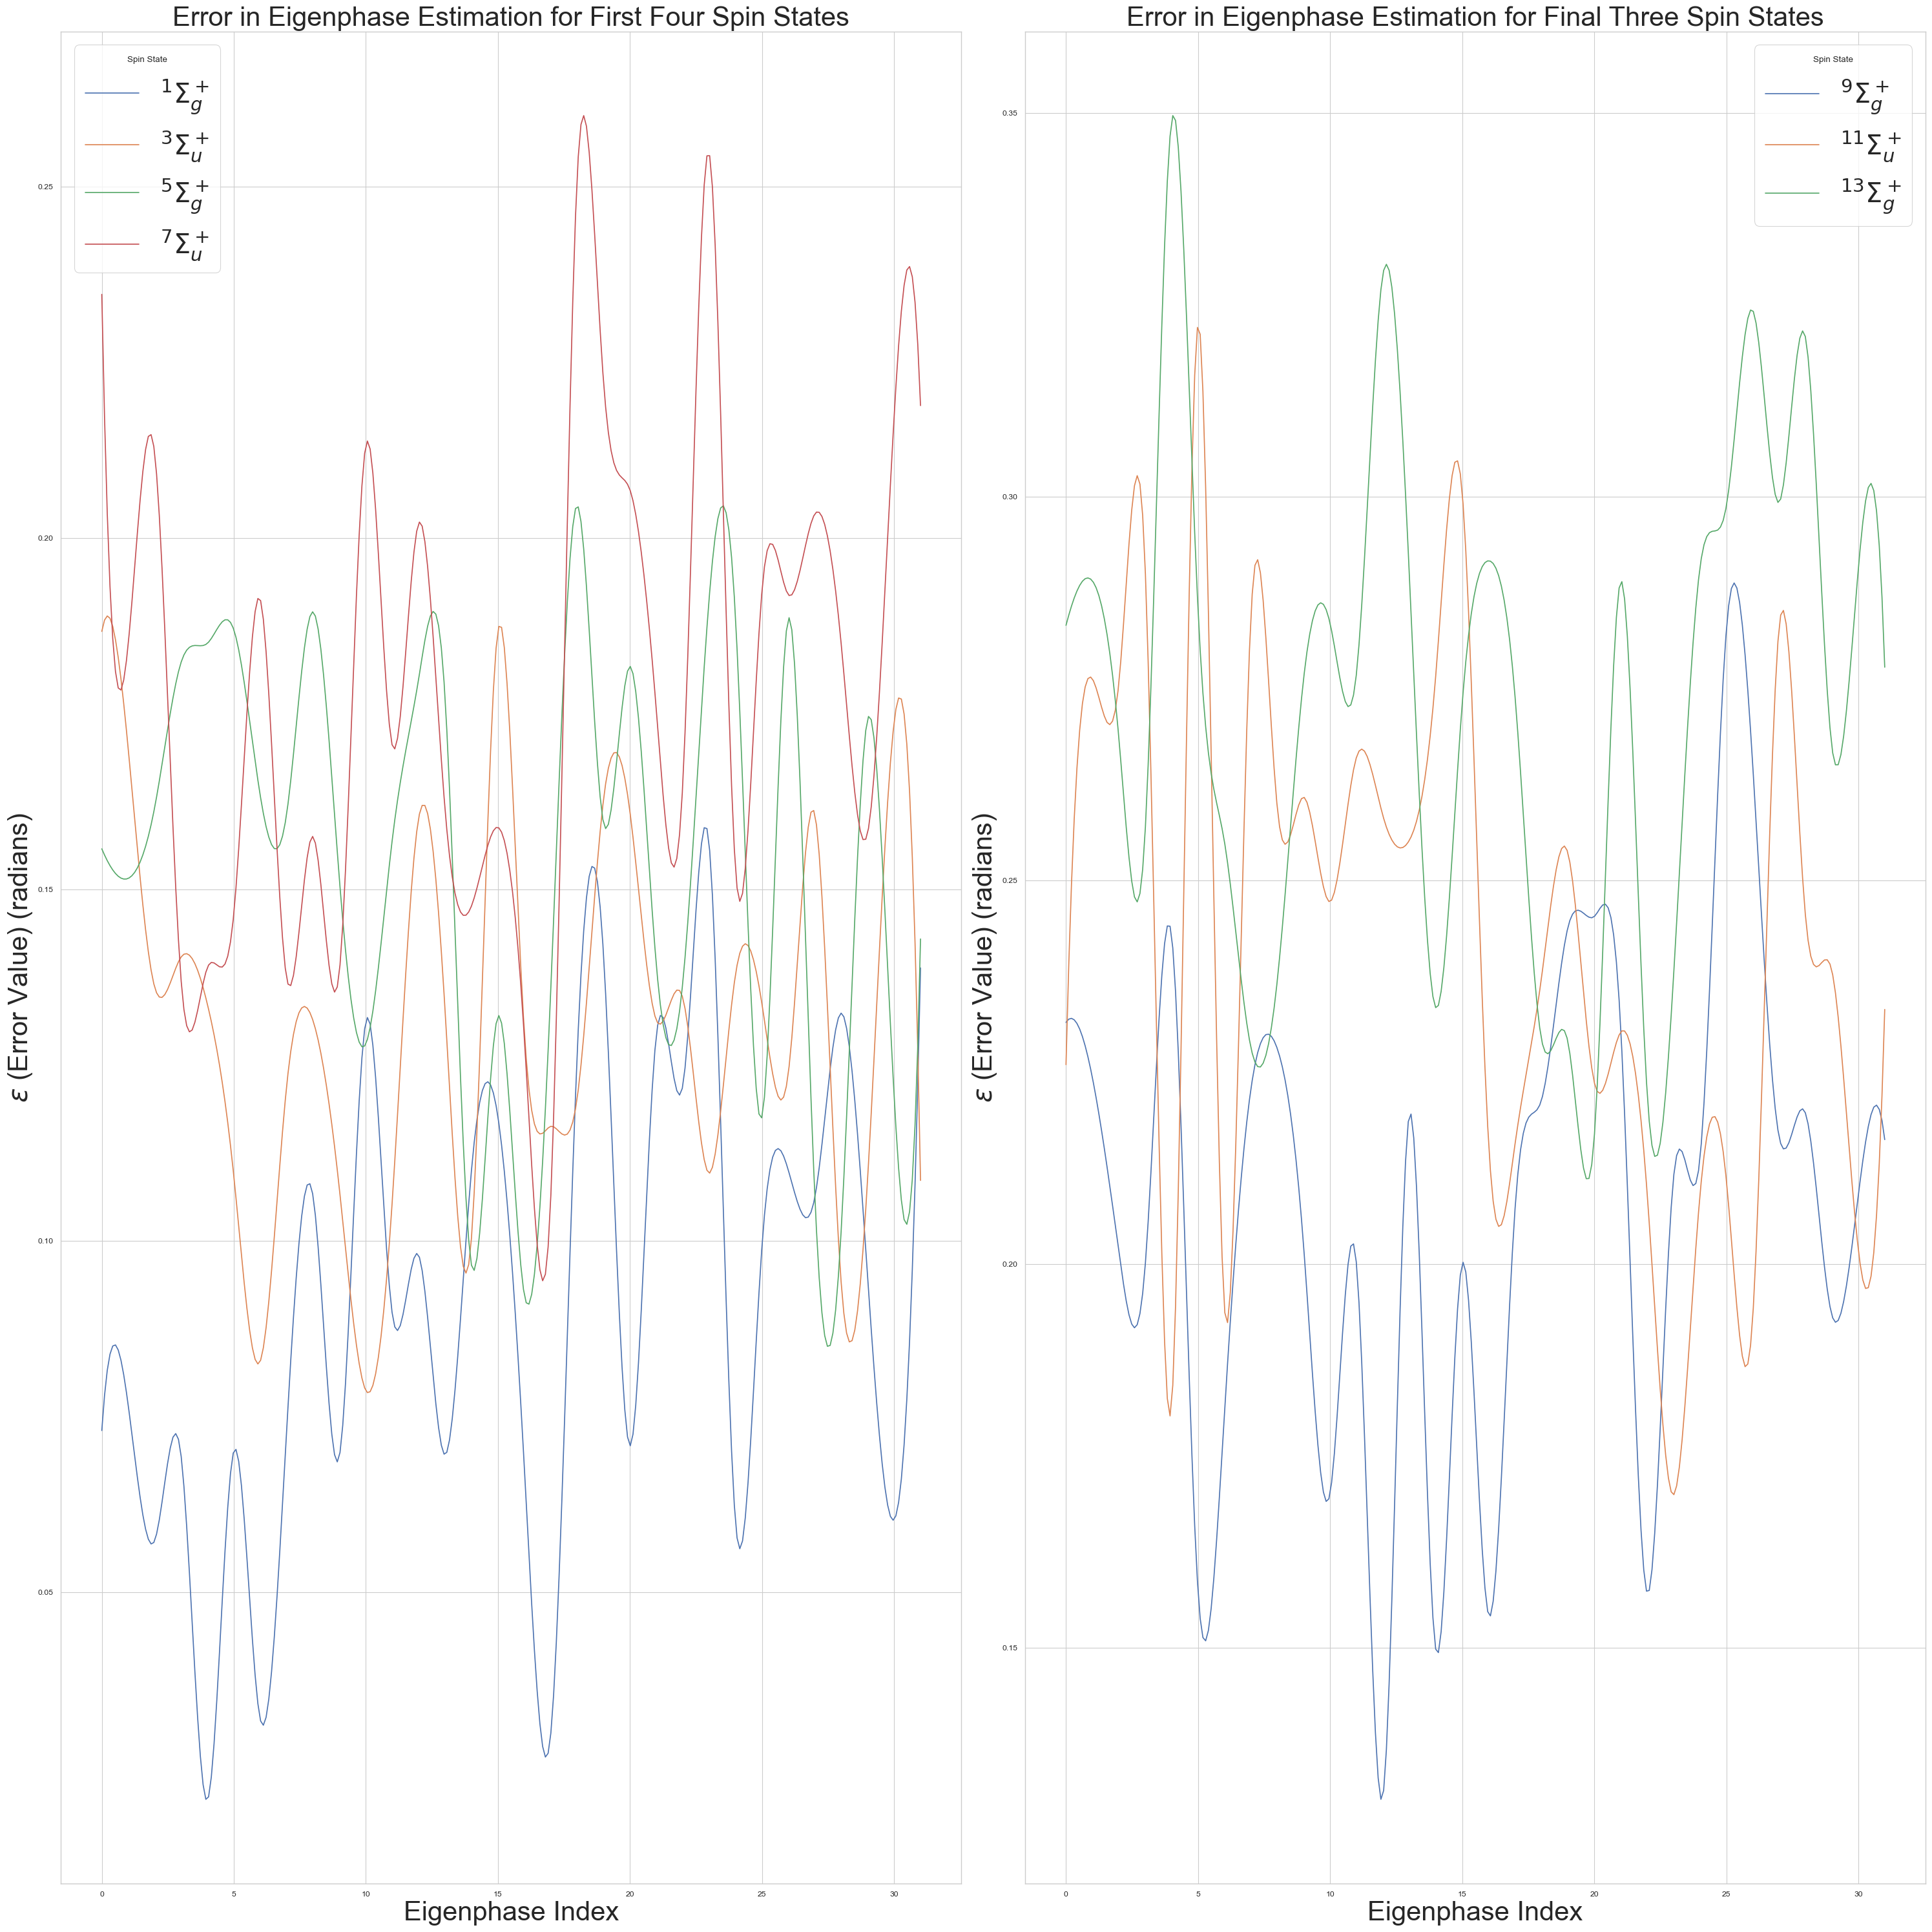

In [10]:

true_phases = [phase1, phase3, phase5, phase7, phase9, phase11, phase13]

error_values = []
for syn_phase, true_phase in zip(average_phases, true_phases): 
    error = np.abs(syn_phase - true_phase)
    error_values.append(error)

phase_indices = np.arange(len(error_values[0]))

labels = ['${}^1\Sigma_g^+$', '${}^3\Sigma_u^+$', '${}^5\Sigma_g^+$', '${}^7\Sigma_u^+$',
          '${}^9\Sigma_g^+$', '${}^{11}\Sigma_u^+$', '${}^{13}\Sigma_g^+$']

offset_increment = 0.03
n = 30
fig, axs = plt.subplots(1, 2, figsize=(n, n)) 
for index, errors in enumerate(error_values[:4]):
    spline = make_interp_spline(phase_indices, errors, k=3)
    smooth_indices = np.linspace(phase_indices.min(), phase_indices.max(), 300)
    smooth_errors = spline(smooth_indices)
    offset_errors = smooth_errors + offset_increment * index
    sns.lineplot(x=smooth_indices, y=offset_errors, label=f'{labels[index]}', ax=axs[0])

axs[0].set_title('Error in Eigenphase Estimation for First Four Spin States', fontsize=n)
axs[0].set_xlabel('Eigenphase Index', fontsize=n)
axs[0].set_ylabel(r'$\epsilon$ (Error Value) (radians)', fontsize=n)
axs[0].legend(title='Spin State', fontsize=n)

for index, errors in enumerate(error_values[4:7]):
    spline = make_interp_spline(phase_indices, errors, k=3)
    smooth_indices = np.linspace(phase_indices.min(), phase_indices.max(), 300)
    smooth_errors = spline(smooth_indices)
    offset_errors = smooth_errors + offset_increment * (index + 4) 
    sns.lineplot(x=smooth_indices, y=offset_errors, label=f'{labels[index + 4]}', ax=axs[1])

axs[1].set_title('Error in Eigenphase Estimation for Final Three Spin States', fontsize=n)
axs[1].set_xlabel('Eigenphase Index', fontsize=n)
axs[1].set_ylabel(r'$\epsilon$ (Error Value) (radians)', fontsize=n)
axs[1].legend(title='Spin State', fontsize=n)

plt.tight_layout() 
plt.show()

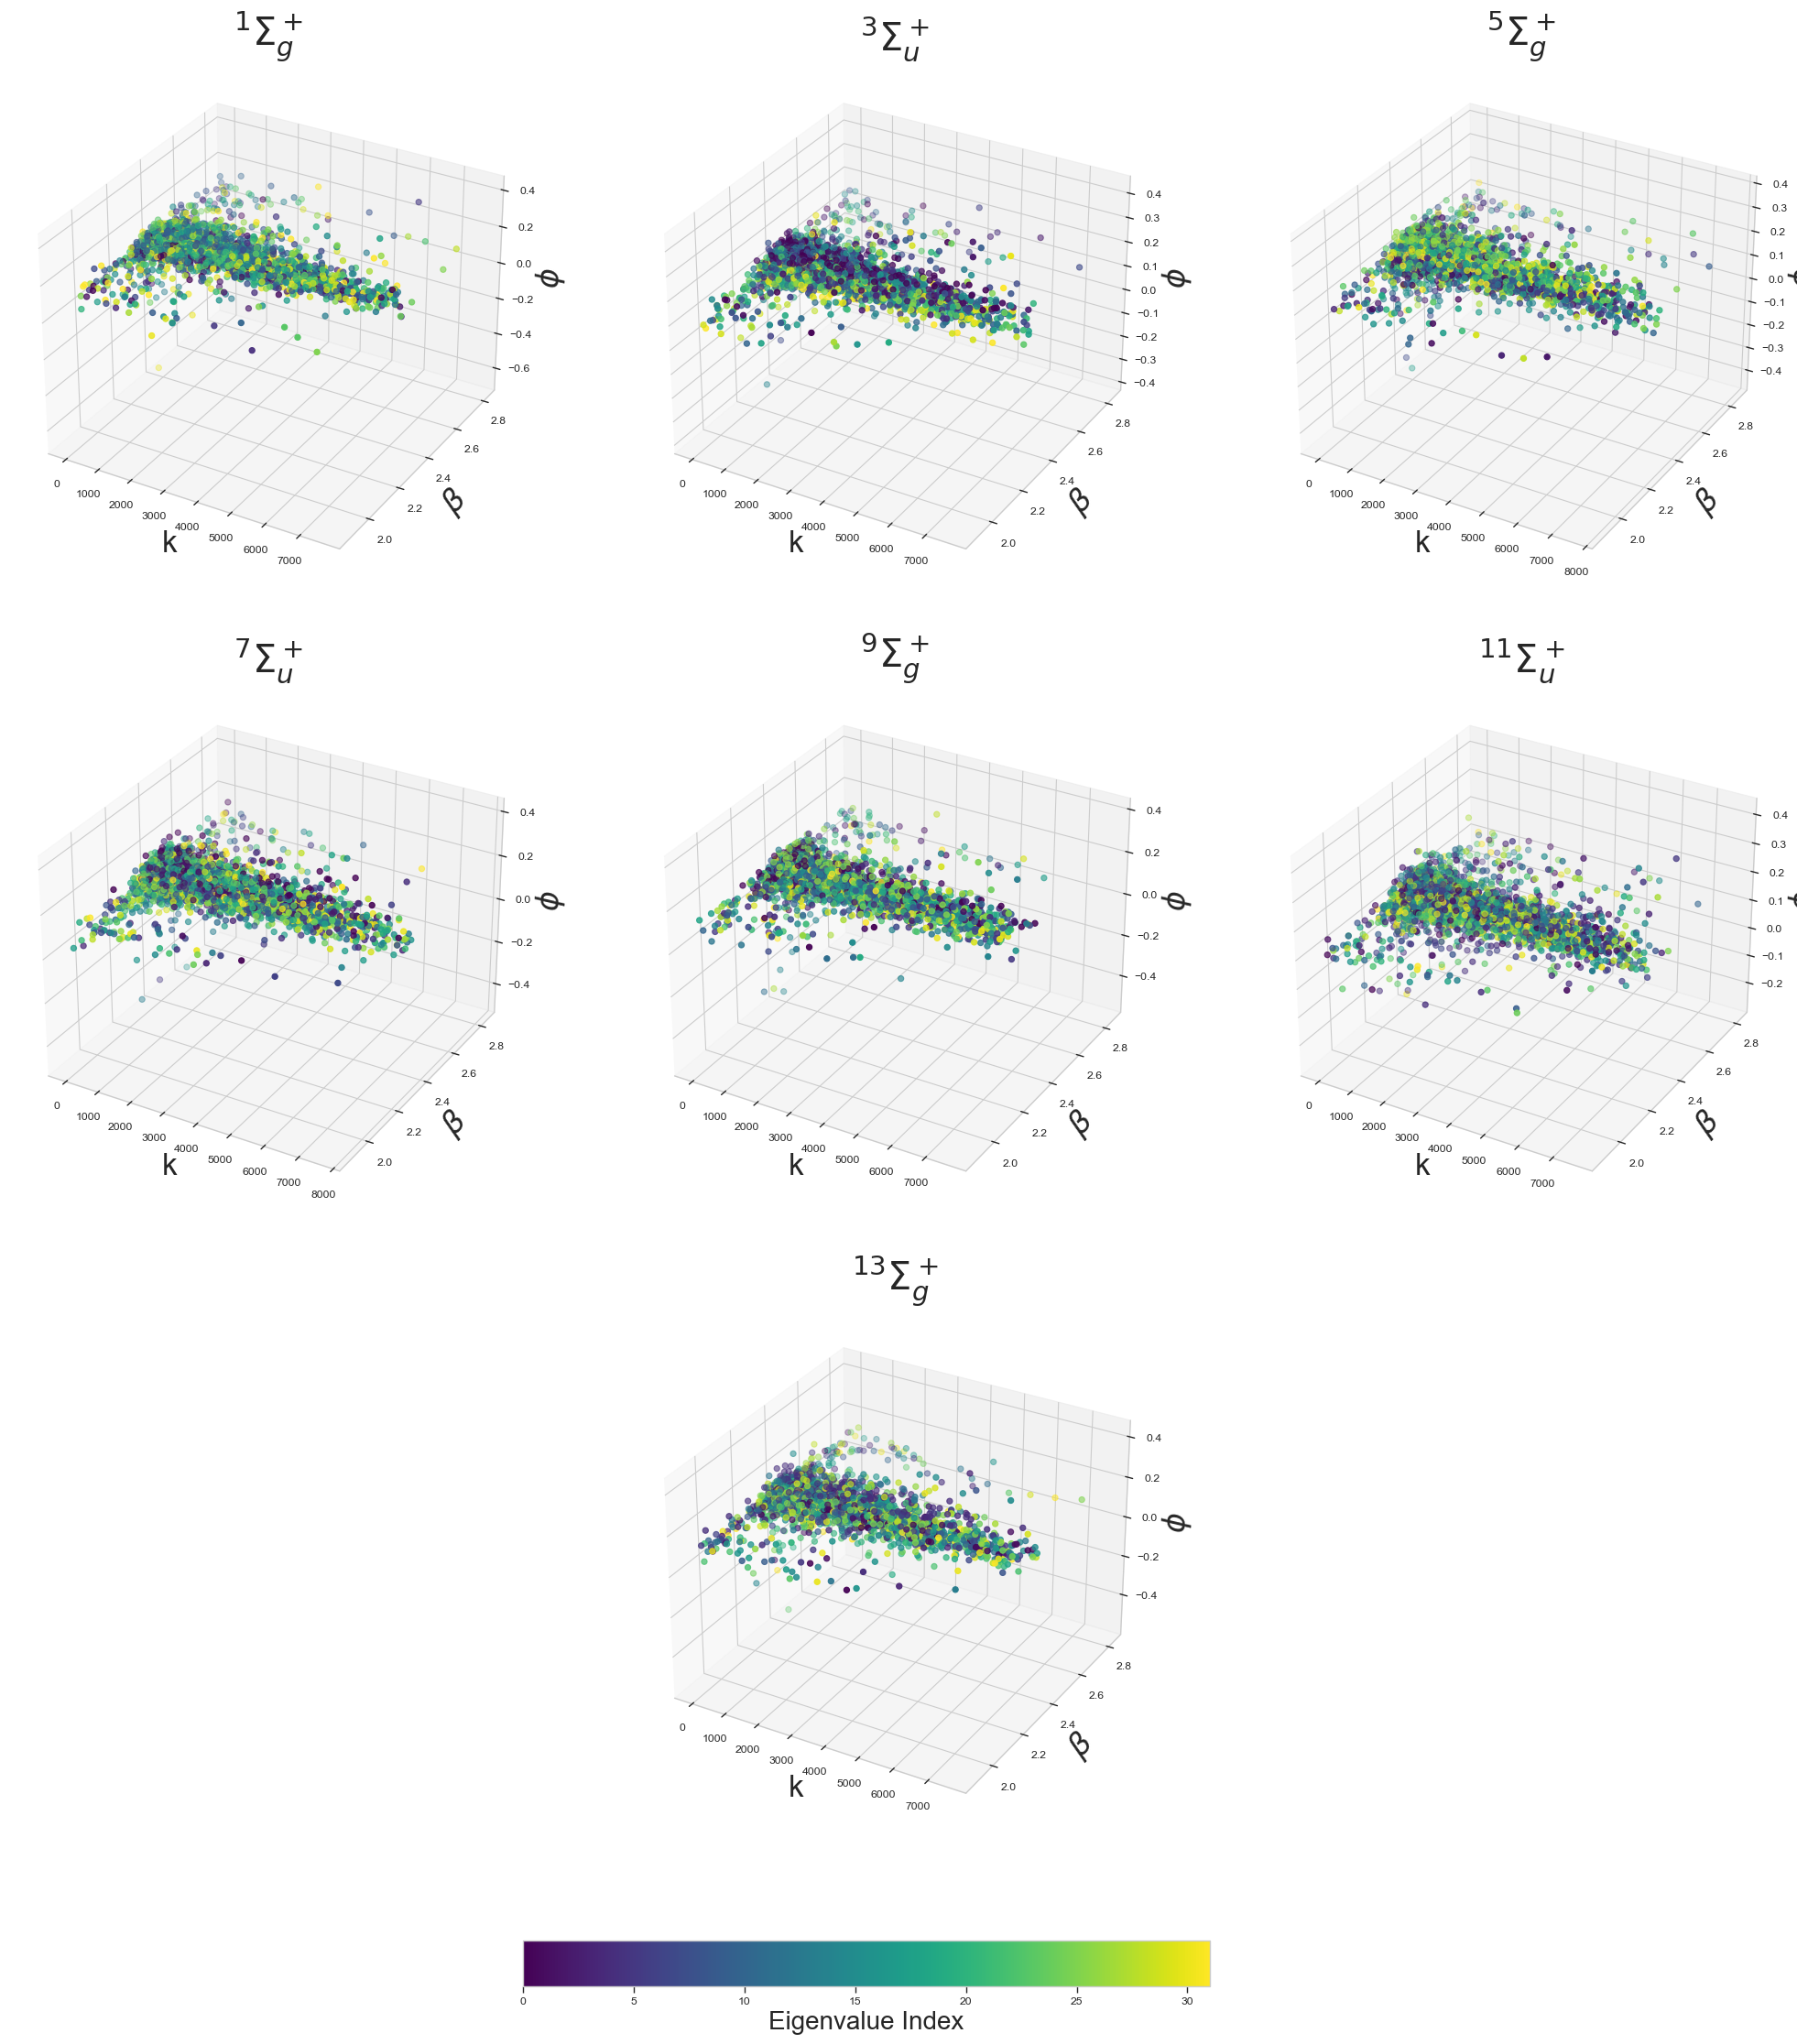

In [11]:
fig = plt.figure(figsize=(25, 25))  
labels = ['${}^1\Sigma_g^+$', '${}^3\Sigma_u^+$', '${}^5\Sigma_g^+$', '${}^7\Sigma_u^+$',
          '${}^9\Sigma_g^+$', '${}^{11}\Sigma_u^+$', '${}^{13}\Sigma_g^+$']

for i in range(7):
    if i < 6:  
        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
    else:  
        ax = fig.add_subplot(3, 3, 8, projection='3d')  

    all_ks = []
    all_betas = []
    all_phases = []
    all_eigenvalue_indices = []

    unitary_results = results[i]  
    for j, eigenvalue_results in enumerate(unitary_results):
        ks = []
        betas = []
        average_phases = []

        for experiment_result in eigenvalue_results:
            k, beta, _, _, average_phase = experiment_result
            ks.append(k)
            betas.append(beta)
            average_phases.append(average_phase)

        all_ks.extend(ks)
        all_betas.extend(betas)
        all_phases.extend(average_phases)
        all_eigenvalue_indices.extend([j] * len(ks))

    all_ks = np.array(all_ks)
    all_betas = np.array(all_betas)
    all_phases = np.array(all_phases)
    all_eigenvalue_indices = np.array(all_eigenvalue_indices)

    scatter = ax.scatter(all_ks, all_betas, all_phases, c=all_eigenvalue_indices, cmap='viridis', marker='o')
    ax.set_xlabel('k',  fontsize=24)
    ax.set_ylabel(r'$\beta$', fontsize=24)
    ax.set_zlabel(r'$\phi$', fontsize=24)
    ax.set_title(labels[i], fontsize=30)

cbar_ax = fig.add_axes([0.35, 0.04, 0.3, 0.02])  
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Eigenvalue Index', fontsize=20)


plt.show()




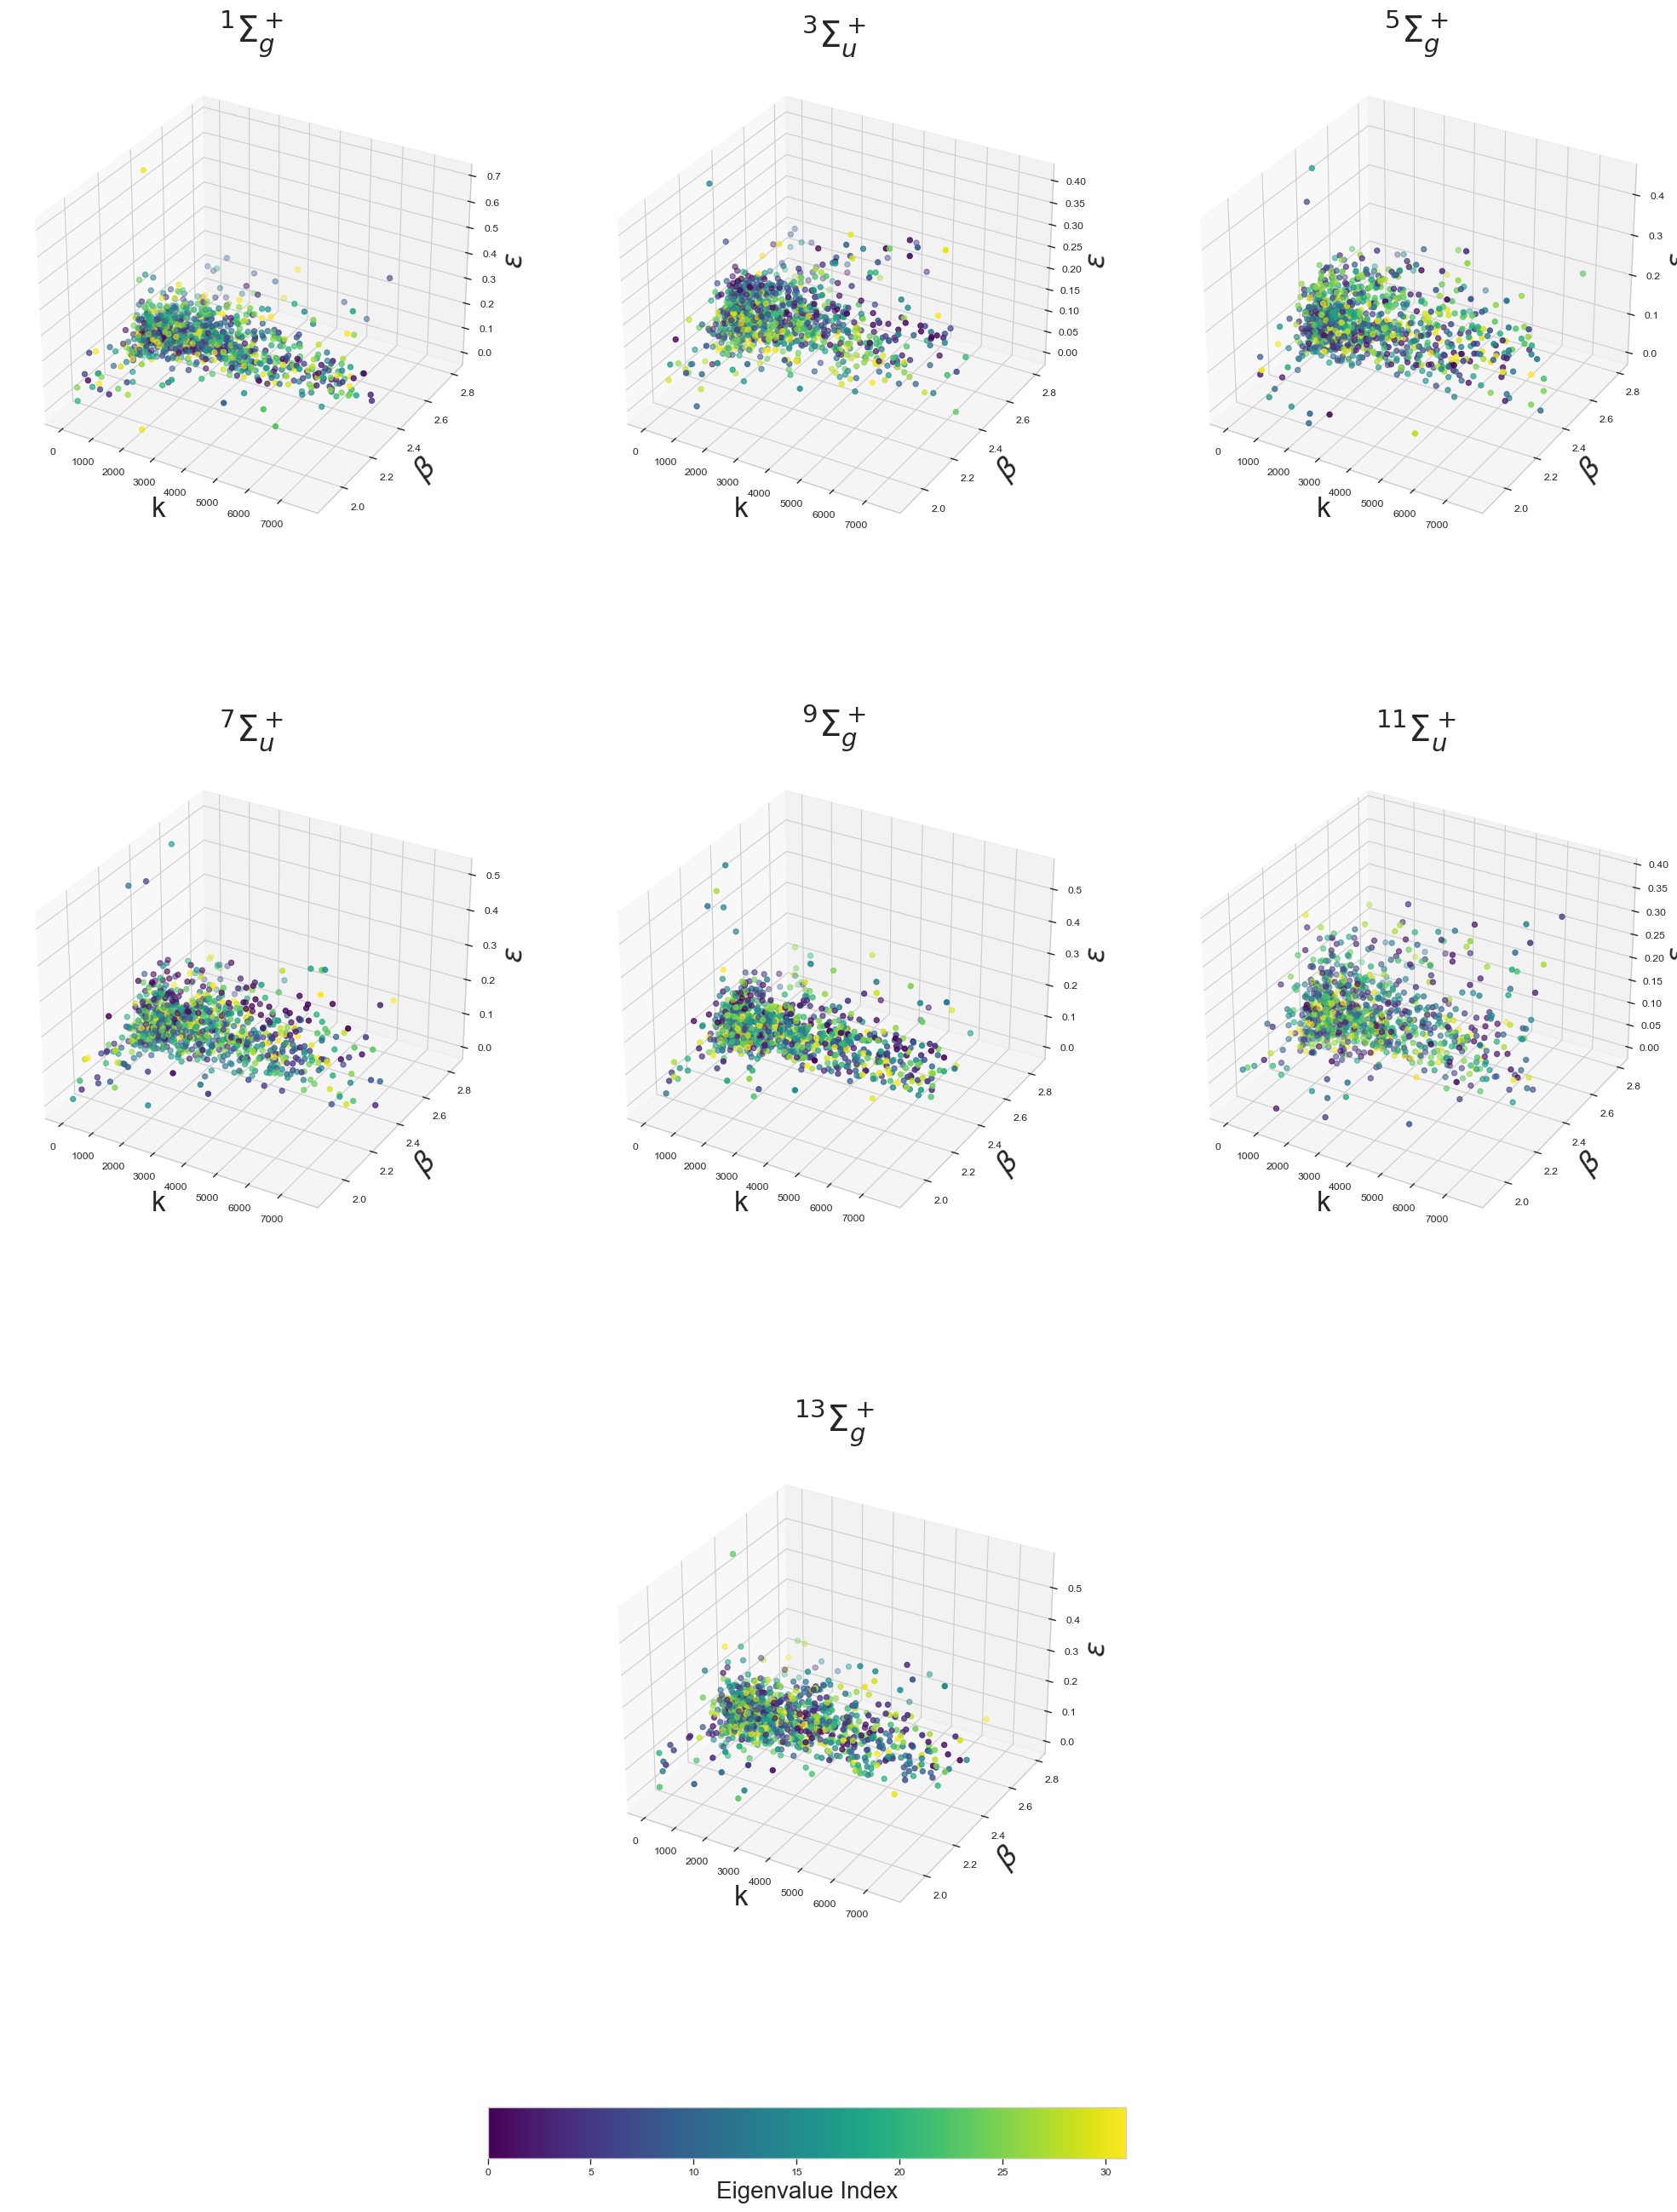

In [12]:
# Assuming 'results' and 'true_phases' are defined somewhere before this code snippet

fig = plt.figure(figsize=(25, 30))
labels = ['${}^1\Sigma_g^+$', '${}^3\Sigma_u^+$', '${}^5\Sigma_g^+$', '${}^7\Sigma_u^+$',
          '${}^9\Sigma_g^+$', '${}^{11}\Sigma_u^+$', '${}^{13}\Sigma_g^+$']

# Assuming 'results' and 'true_phases' are defined somewhere before this code snippet

for i in range(7):
    if i < 6:
        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
    else:
        ax = fig.add_subplot(3, 3, 8, projection='3d')

    all_ks = []
    all_betas = []
    all_errors = []
    all_eigenvalue_indices = []

    unitary_results = results[i]
    true_phase = true_phases[i]

    for j, eigenvalue_results in enumerate(unitary_results):
        ks = []
        betas = []
        errors = []
        for experiment_result, true_phase_value in zip(eigenvalue_results, true_phase):
            k, beta, _, _, average_phase = experiment_result
            ks.append(k)
            betas.append(beta)
            errors.append(np.abs(average_phase - true_phase_value))

        all_ks.extend(ks)
        all_betas.extend(betas)
        all_errors.extend(errors)
        all_eigenvalue_indices.extend([j] * len(ks))

    all_ks = np.array(all_ks)
    all_betas = np.array(all_betas)
    all_errors = np.array(all_errors)
    all_eigenvalue_indices = np.array(all_eigenvalue_indices)

    scatter = ax.scatter(all_ks, all_betas, all_errors, c=all_eigenvalue_indices, cmap='viridis', marker='o')
    ax.set_xlabel('k', fontsize=24)
    ax.set_ylabel(r'$\beta$', fontsize=24)
    ax.set_zlabel(r'$\epsilon$', fontsize=24)
    ax.set_title(labels[i], fontsize=30)

# Add color bar
cbar_ax = fig.add_axes([0.35, 0.04, 0.3, 0.02])
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Eigenvalue Index', fontsize=20)

plt.show()



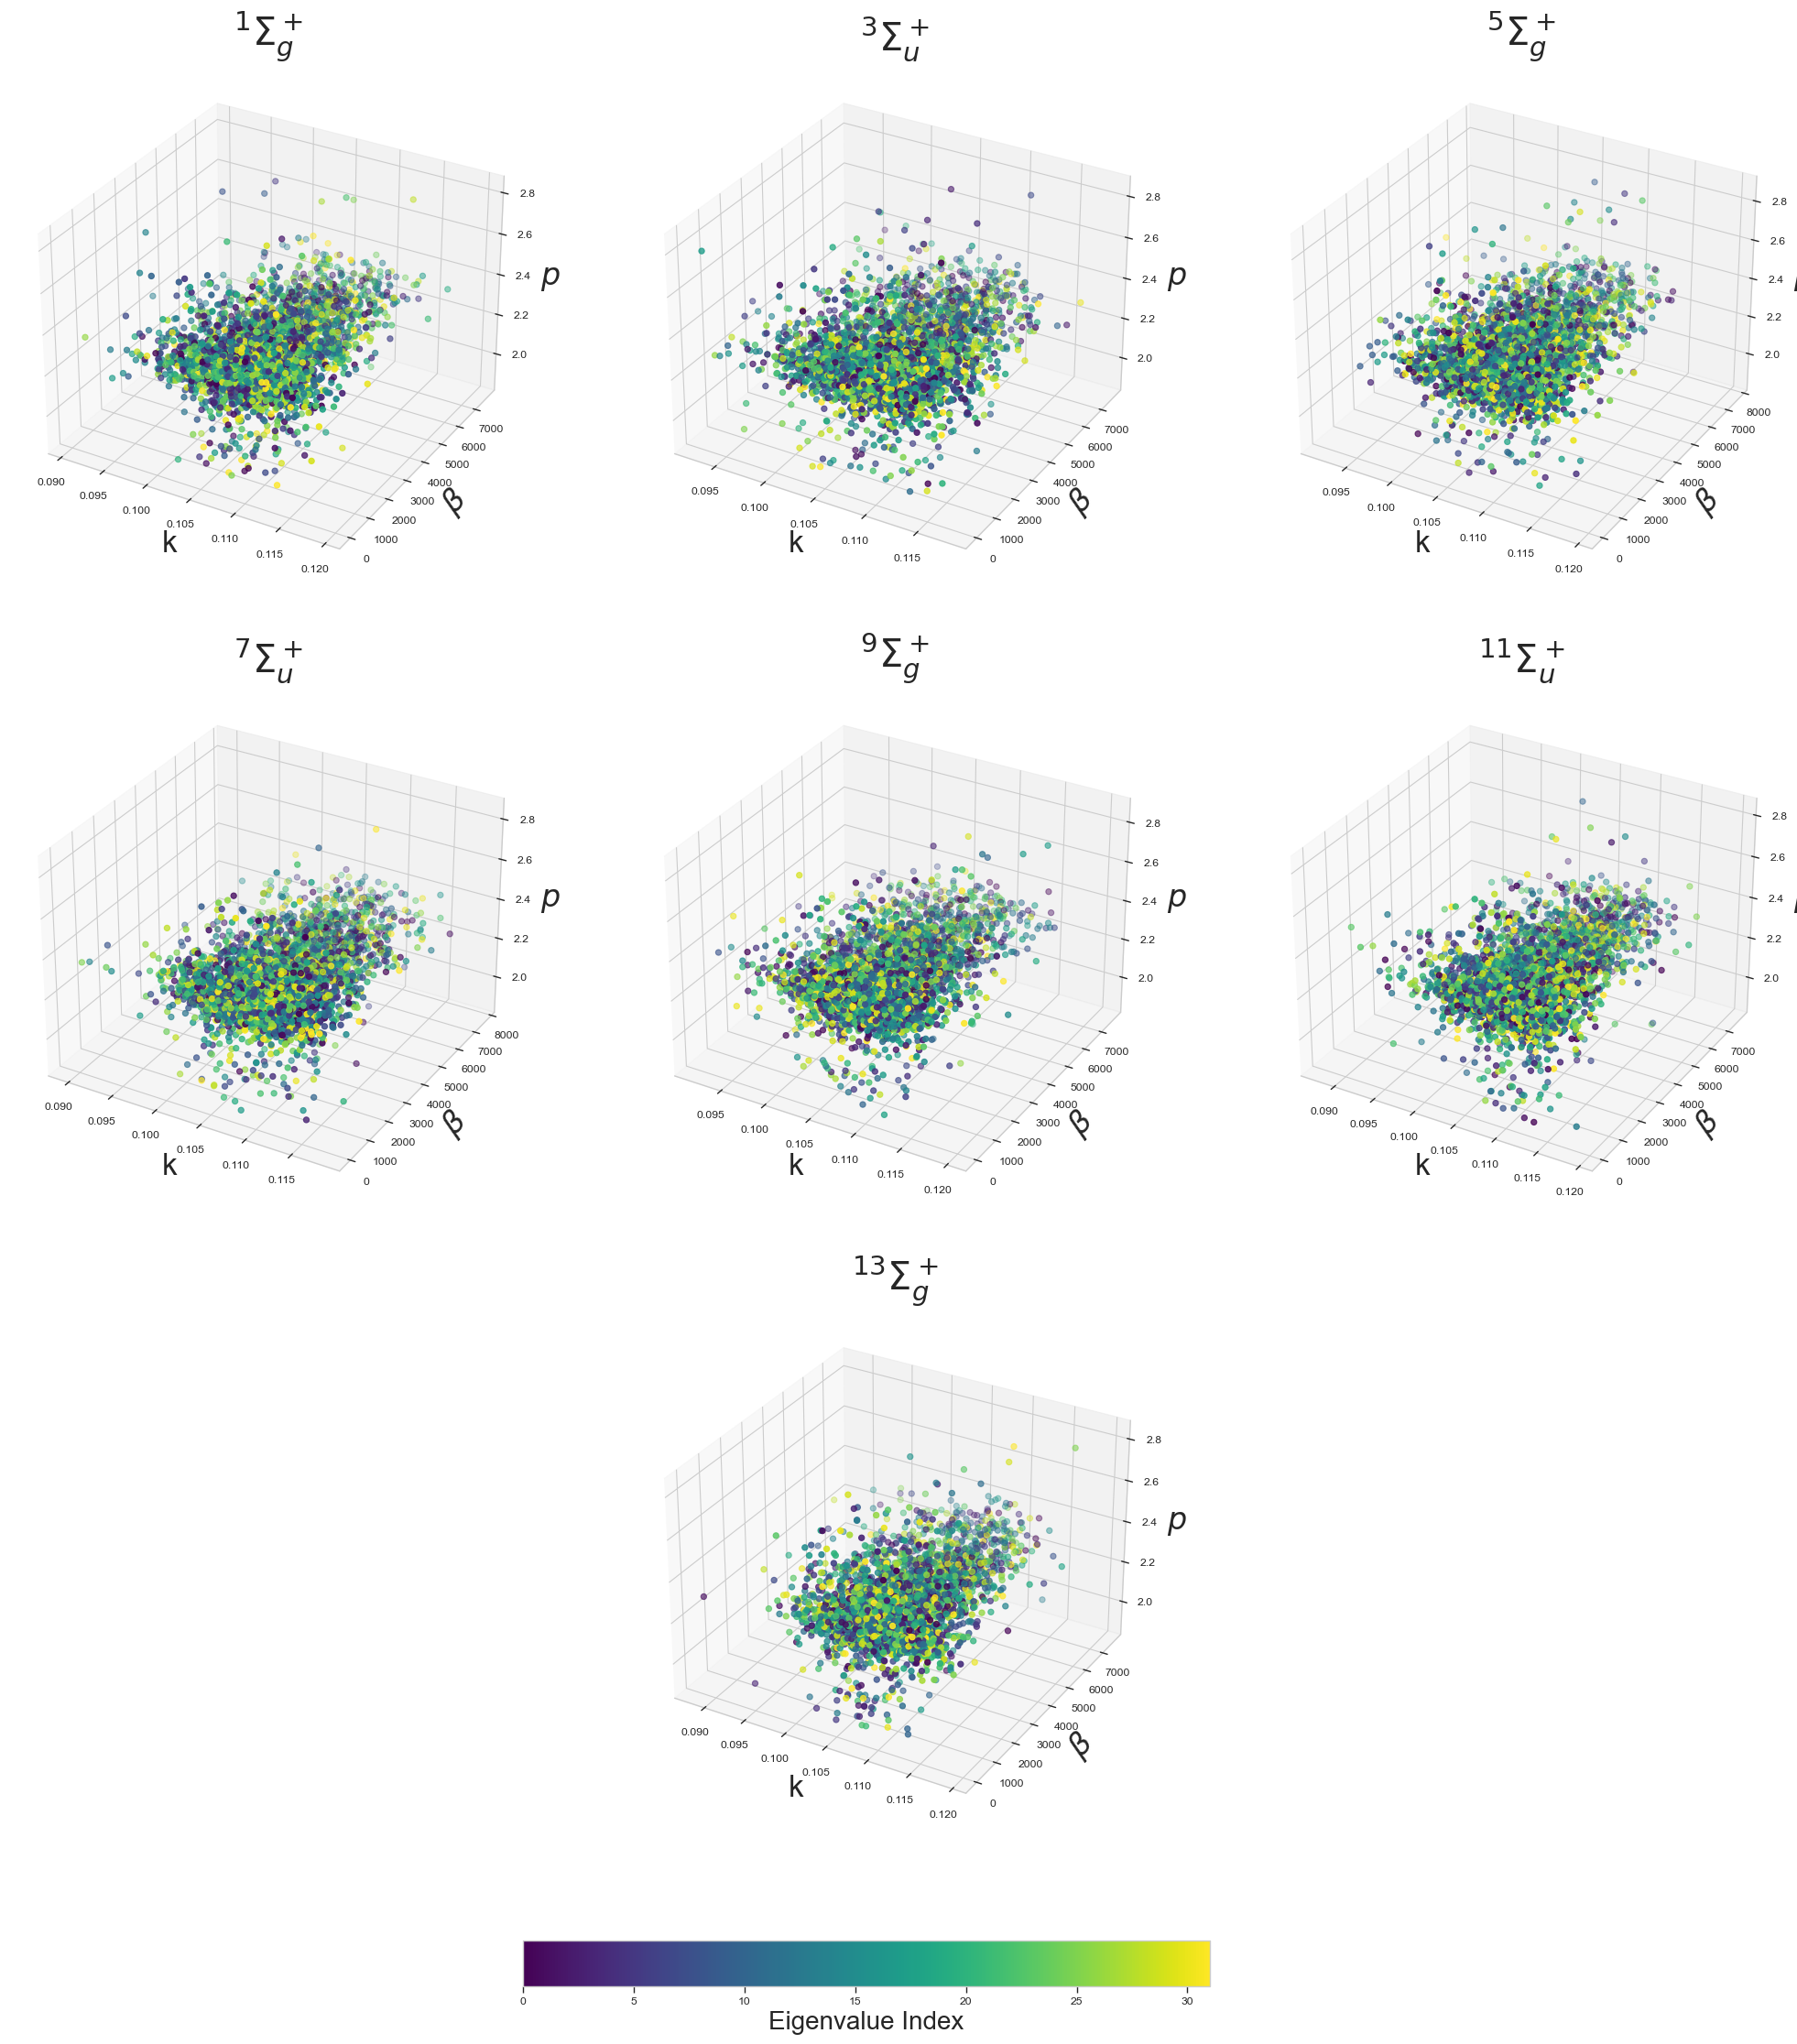

In [13]:
fig = plt.figure(figsize=(25, 25))  
labels = ['${}^1\Sigma_g^+$', '${}^3\Sigma_u^+$', '${}^5\Sigma_g^+$', '${}^7\Sigma_u^+$',
          '${}^9\Sigma_g^+$', '${}^{11}\Sigma_u^+$', '${}^{13}\Sigma_g^+$']

for i in range(7):
    if i < 6:  
        ax = fig.add_subplot(3, 3, i + 1, projection='3d')
    else:  
        ax = fig.add_subplot(3, 3, 8, projection='3d')  

    all_ks = []
    all_betas = []
    all_phases = []
    all_eigenvalue_indices = []

    unitary_results = results[i]  
    for j, eigenvalue_results in enumerate(unitary_results):
        ks = []
        betas = []
        average_phases = []

        for experiment_result in eigenvalue_results:
            k, beta, _, fourier_basis_probs, _, = experiment_result
            ks.append(k)
            betas.append(beta)
            average_phases.append(np.mean(fourier_basis_probs))
            
        all_ks.extend(ks)
        all_betas.extend(betas)
        all_phases.extend(average_phases)
        all_eigenvalue_indices.extend([j] * len(ks))

    all_ks = np.array(all_ks)
    all_betas = np.array(all_betas)
    all_phases = np.array(all_phases)
    all_eigenvalue_indices = np.array(all_eigenvalue_indices)

    scatter = ax.scatter(all_phases, all_ks, all_betas, c=all_eigenvalue_indices, cmap='viridis', marker='o')
    ax.set_xlabel('k',  fontsize=24)
    ax.set_ylabel(r'$\beta$', fontsize=24)
    ax.set_zlabel(r'$p$', fontsize=24)
    ax.set_title(labels[i], fontsize=30)

cbar_ax = fig.add_axes([0.35, 0.04, 0.3, 0.02])  
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Eigenvalue Index', fontsize=20)


plt.show()